## Goal: Design a PI Controller

This will be achieved by frequency response design / pole placement. Each cell will have an individual goal it's trying to achieve!

[ 1 10 24]

Gol: 
      10
---------------
s^2 + 10 s + 24

Open loop low freq gain: 0.4166666666666667
Steady state error for unit step: 0.7058823529411764


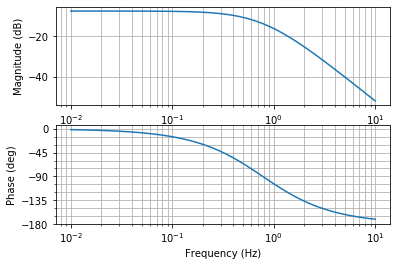

In [254]:
#Module goal: set up initial system bode plot. estimate offset.

import math as m
import numpy as np
import control as ctr
import control.matlab as ml
import matplotlib.pyplot as plt

#plant - lumped model - process, actuator, and sensor
#Transfer function for open loop feedback system:
Kp1 = 10
Tau1 = 1
num = Kp1
den = np.polymul(np.array([1,4]), np.array([1, 6]))
print(den)

Gol = ml.tf(num, den)
print(f"\nGol: {Gol}")
gain, phase, w = ml.bode(Gol)

dcg = ml.dcgain(Gol)
SSE = 1/(1 + dcg)   #for a unit step
print(f"Open loop low freq gain: {dcg} (-7.6 dB)")
print(f"Steady state error for unit step: {SSE}")


Our system:
 
        10 s^2 + 100 s + 240
------------------------------------
s^4 + 20 s^3 + 158 s^2 + 580 s + 816
 

Type: Second order process (2 zeros cancel 2 poles)
[0.000e+00 1.000e-02 2.000e-02 ... 1.097e+01 1.098e+01 1.099e+01]


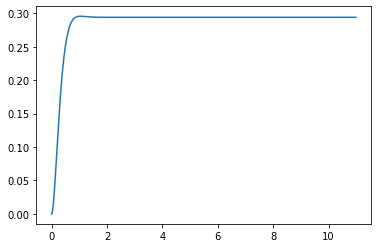

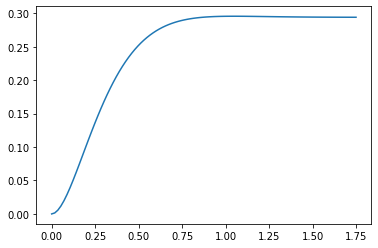

In [255]:
#Create closed loop version. Simulate response to step change input of one:

Gcl = Gol / (1+ Gol)
Gcl

print(f"Our system:\n {Gcl} \n\nType: Second order process (2 zeros cancel 2 poles)")

T = np.arange(0,11, .01)
t, y = ctr.step_response(Gcl, T=T,X0=0)
ym, tm = ml.step(Gcl)

fig, ax = plt.subplots()
ax.plot(t, y)

fig, ax = plt.subplots()
ax.plot(tm, ym)

print(T)


Gol Unstable: 
      216
---------------
s^2 + 10 s + 24


Phase Margin: 39.682948763360855 
(Crossover Frequency: 13.792438420306343)



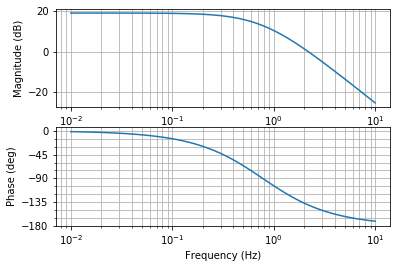

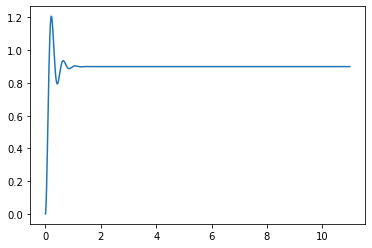

In [256]:
#Current system is actually stable...lets run with an unstable one:

#Adjust gain to add instability
Kp1 = 10*21.6
Tau1 = 1
num = Kp1
den = np.polymul(np.array([1,4]), np.array([1, 6]))

Goluns = ml.tf(num, den)
print(f"\nGol Unstable: {Goluns}")
gain, phase, w = ml.bode(Goluns)   #now we have a phase crossover frequency


gm, pm, wcg, wcp = ml.margin(Goluns)
print(f"\nPhase Margin: {pm} \n(Crossover Frequency: {wcp})\n")



#Close loop and simulate unit step input
Gcluns = Goluns/ (1 + Goluns)
y2, t2 = ml.step(Gcluns, T=T)   #for some reason matlab defaults to yout, tout...
fig, ax = plt.subplots()
ax.plot(t2, y2)                     #Notice some overshoot, but less offset



Gol: 
        10
-------------------
s^3 + 10 s^2 + 24 s



The Numbers:
Open loop low freq gain: inf
Steady state error for unit step: 0.0

Gain Margin: 23.999999999999996
(Critical Frequency: 4.898979485566356) 

Phase Margin: 80.15614219912669 
(Crossover Frequency: 0.4134776203621549)

             10 s^3 + 100 s^2 + 240 s
--------------------------------------------------
s^6 + 20 s^5 + 148 s^4 + 490 s^3 + 676 s^2 + 240 s



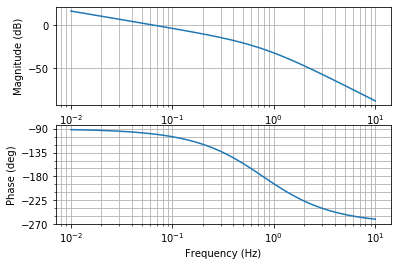

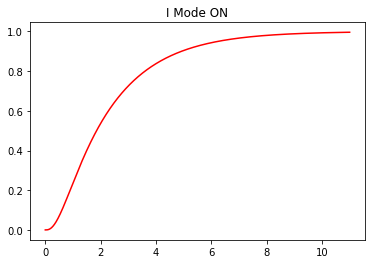


Phase lift: 
      1
------------
0.7246 s + 1


Golint2: 
    7.246 s + 10
-------------------
s^3 + 10 s^2 + 24 s

(-0.04124775847370433-0.04111547167592675j)
0.05823967367902212
-24.69562134141311
45.08904901221825

Gain Margin: inf
(Critical Frequency: nan) 

Phase Margin: 45.16265544735657 
(Crossover Frequency: 9.93202520045672)
Warning (matlab.bode): plot styles not implemented


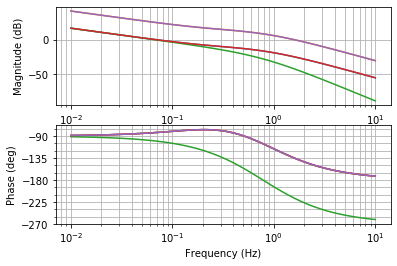

In [260]:
#Add PI Controller


#Add integrator to og system:

Golint = Gol*ml.tf(1,[1,0])
print(f"\nGol: {Golint}")
gain, phase, w = ml.bode(Golint)

#We see that with just the I mode turned on, the system is still stable
#The numbers:
print("\n\nThe Numbers:")
dcg = ml.dcgain(Golint)
SSE = 1/(1 + dcg)   #for a unit step
print(f"Open loop low freq gain: {dcg}")
print(f"Steady state error for unit step: {SSE}")

gm, pm, wcg, wcp = ml.margin(Golint)
print(f"\nGain Margin: {gm}\n(Critical Frequency: {wcg}) \n\nPhase Margin: {pm} \n(Crossover Frequency: {wcp})")

#Hows the time domain response to a unit step?

Gclint = Golint / (1 + Golint)
print(Gclint)
y3, t3 = ml.step(Gclint, T=T)
fig, ax = plt.subplots()
ax.plot(t3,y3,color='Red')
ax.set_title("I Mode ON")
plt.show()

#Is the system too slow??? Response time is like 10x longer. Speed up w a zero:
##Note how the crossover freq went from 13.8 to 0.4...indeed, we have a much slower response (~10x)
##ie a lot of phase margin. Lets do a phase lift at 13.8 Hz, ie add a zero one decade before that


##double checking##
print(ctr.evalfr(Golint2, 10j))
b = m.sqrt((0.04124775847370433)**2 +(0.04111547167592675)**2)
print(b)
print(20*(m.log10(b)))
print(m.atan2(0.04124775847370433,0.04111547167592675)*180/3.1418)
#^^double checking^^#


Golint2 = Golint*ml.tf(np.array([1/1.38, 1]),1)
zero = ml.tf(1,np.array([1/1.38, 1]))
print(f"\nPhase lift: {zero}")

print(f"\nGolint2: {Golint2}")
gain, phase, w = ml.bode(Golint2)


#Now have a phase of -135deg at 10 Hz. A phase margin of 45deg would be pretty good so...
#lets try to achieve that by increasing the gain trace --> location of 0 dB

#Want 20log(K) = 0 at 10 Hz. The current K[w=10] is -24.6 dB  so:
Kc = 10**(24.6/20)
Golint3 = Golint2*Kc
gain, phase, w = ml.bode(Golint3) #Not sure why this one's combined....but im not opposed



gm, pm, wcg, wcp = ml.margin(Golint3)
print(f"\nGain Margin: {gm}\n(Critical Frequency: {wcg}) \n\nPhase Margin: {pm} \n(Crossover Frequency: {wcp})")


gain, phase, w = ml.bode(Golint, 'plotstlye1', Golint2, 'plotstlye2', Golint3,'plotstlye3')

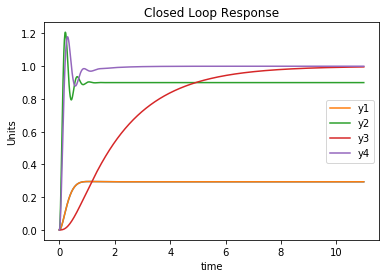

In [258]:
#Close loop and simulate unit step input
Gclint3 = Golint3/ (1 + Golint3)
y4, t4 = ml.step(Gclint3, T, 0)
fig, ax = plt.subplots()
ax.plot(t, y)  
ax.set_title("Closed Loop Responses")
ax.set_xlabel("time")
ax.set_ylabel("Units")

plt.plot(t,y, label="y1")    #Original system - the plant
plt.plot(t2,y2, label="y2")  #Higher gain version
plt.plot(t3,y3, label="y3")  #With an I only controller
plt.plot(t4,y4, label='y4')  #With PI controller + added zero / Lead compensator
plt.legend()